In [1]:
##this is to test the efficacy of medusa over the internal cobra gapfiller


import cobra
from cobra import Metabolite, Gene, Reaction
import pandas as pd
import medusa
from medusa.test import load_universal_modelseed
import matplotlib.pylab as plt
import pandas as pd


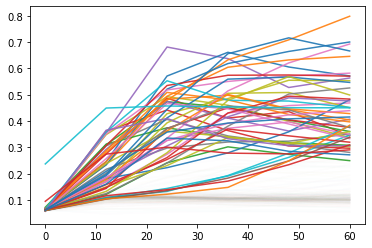

In [2]:
# loop through the sheets of the spreadsheet; each sheet is a biological replicate
# of all 3 of the biolog plates. Columns are time in hours.
reps = {}
for i in range(0,4):
    biolog_raw = pd.read_excel('../data/experiments/biolog_raw.xlsx',sheet_name="rep_"+str(i+1))
    biolog_raw.columns = [col for col in biolog_raw.columns]
    reps[i] = biolog_raw
    
all_biolog = pd.concat([reps[0],reps[1],reps[2],reps[3]])
    
# convert to mean and std at each time point, 
# and get the max OD at all time points (from means)
mets = reps[0].index.unique()
means = {}
stds = {}
maxODs = {}
for met in mets:
    vals = pd.DataFrame()
    concat_axis = 1
    if met == 'Neg':
        concat_axis = 0
    
    for rep in reps:
        vals = pd.concat([vals,reps[rep].loc[met]],axis=concat_axis)
    
    if met != 'Neg':
        vals = vals.T
    
    means[met] = vals.mean()
    stds[met] = vals.std()
    maxODs[met] = means[met].max()

fig,ax = plt.subplots()
for met in means.keys():
    plotvals = means[met]
    if maxODs[met] > 0.3:
        alpha = 0.9
    else:
        alpha = 0.01
    ax.plot(plotvals.index.values,plotvals.values,alpha=alpha,label = met)
       

In [3]:
vals.to_csv("../data/all_biolog.csv")

In [4]:
# threshold the growth data to get positive growth conditions only
growth_threshold = 0.3
positive_growth_conditions = {condition:maxODs[condition] for condition in maxODs.keys() if maxODs[condition] > growth_threshold}
phenotypes = pd.DataFrame.from_dict(positive_growth_conditions,orient='index')
phenotypes.columns = ["Max OD"]

# Read in the bioog:seed file and merge with the positive growth data to get SEED compound ids for each metabolite
biolog_to_seed = pd.read_csv('../data/biolog_names_to_seed.tsv', sep = '\t')
biolog_to_seed.index = biolog_to_seed["name"]
biolog_to_seed = biolog_to_seed.drop("name", axis=1)
carbon_sources = phenotypes.index.tolist()
phenotypes = phenotypes.merge(biolog_to_seed, left_index=True, right_index=True)
carbon_sources_post_merge = phenotypes.index.tolist()
# Print out the metabolites missing identifiers. These might be expected (e.g. pectin is a polymer that
# cannot be properly represented, so we don't include it)
print("The following compounds are missing; is this expected?", set(carbon_sources) - set(carbon_sources_post_merge))

The following compounds are missing; is this expected? {'Pectin'}


In [5]:
# Load the biolog data from Plata et al., Nature 2014
from medusa.test import load_biolog_plata
biolog_base_composition, biolog_base_dict, biolog_thresholded = load_biolog_plata()
biolog_base_composition = biolog_base_composition.drop(18)
if "cpd00028_e" in biolog_base_dict:
    del biolog_base_dict["cpd00028_e"]
biolog_base_composition

,Name,ID
0,H2O,cpd00001_e
1,O2,cpd00007_e
2,Phosphate,cpd00009_e
3,CO2,cpd00011_e
4,NH3,cpd00013_e
5,Mn2+,cpd00030_e
6,Zn2+,cpd00034_e
7,Sulfate,cpd00048_e
8,Cu2+,cpd00058_e
9,Ca2+,cpd00063_e


In [2]:
# load the universal reaction database
from medusa.test import load_universal_modelseed
from cobra.core import Reaction
import cobra

# load the modelseed universal model. This will take a few minutes.
universal = load_universal_modelseed()

# load the psuedomonas syringae draft recon
seed_draft = cobra.io.load_json_model('../data/modelseed_data/modelseed_draft_psy_DC3000.json')

# add all reactions from the draft to the universal if they are not already present
add_to_universal = []
for rxn in seed_draft.reactions:
    if rxn.id != 'bio1':
        if rxn.id not in [r.id for r in universal.reactions]:
            add_to_universal.append(rxn.copy())

universal.add_reactions(add_to_universal)

In [3]:
##for gapfilling purposes, also load in the universal seed model to pool with reactions from model
model = cobra.io.read_sbml_model("../results/reconstructions/pst6_cor.xml")


In [8]:
# Swap out the biomass function for the one from the draft
model.remove_reactions(['biomass_pto', 
                        'protein' , 
                        'pslpd_c', "pslpdhg_c", 'pslpdfa_c', 
                        'rna' , 
                        'dna', "EX_biomass", 'cor0001_c' , 'cor0002_c',
                       'cor0003_c', 'cor0004_c', 'cor0005_c', 'cor0006_c', 'cor0007_c',
                       'cor0008_c' , 'cor0009_c', 'cor0010_c', 'cor0011_c', 'cor0012_c','EX_cpd16565_e'] , remove_orphans = True)
#model.add_reaction(seed_draft.reactions.get_by_id('bio1').copy())
#model.objective = 'bio1'

In [9]:
add_mets = []
add_exchanges = []
for met in list(biolog_base_dict.keys()):
    try:
        model.metabolites.get_by_id(met)
    except:
        print('no '+met)
        add_met = universal.metabolites.get_by_id(met).copy()
        add_mets.append(add_met)

for met in list(biolog_base_dict.keys()):
    # Search for exchange reactions
    try:
        model.reactions.get_by_id('EX_'+met)
    except:
        add_met = universal.metabolites.get_by_id(met)
        ex_rxn = Reaction('EX_' + met)
        ex_rxn.name = "Exchange reaction for " + met
        ex_rxn.lower_bound = -1000
        ex_rxn.upper_bound = 1000
        ex_rxn.add_metabolites({add_met:-1})
        add_exchanges.append(ex_rxn)
        if add_met.id not in [m.id for m in add_mets]:
            add_mets.append(add_met)

no cpd00007_e
no cpd00011_e
no cpd00030_e
no cpd00063_e
no cpd00099_e
no cpd00254_e
no cpd10515_e
no cpd00268_e


In [10]:
# Find metabolites from the biolog data that are missing in the test model
# and add them from the universal
missing_mets = []
missing_exchanges = []
media_dicts = {}

# remove duplicate conditions by using a set
for met_id in set(phenotypes['seed_id'].tolist()):
    media_dict = biolog_base_dict.copy()
    
    for single_met_id in met_id.split(','):
        # make a boolean indicator for metabolites missing from both
        # the model and the universal model
        missing = False
        
        # add the _e suffix for extracellular metabolites
        single_met_id = single_met_id + '_e'
        
        # search for the metabolite in the model.
        # If missing, try to find it in the universal.
        if single_met_id in [m.id for m in model.metabolites]:
            met = model.metabolites.get_by_id(single_met_id)
        else:
            if single_met_id in [m.id for m in universal.metabolites]:
                met = universal.metabolites.get_by_id(single_met_id)
            else:
                print(single_met_id + ' not in universal. Ignoring metabolite.')
                missing = True
        
        # If the metabolite was in the universal or the model,
        # check for an existing exchange reaction. If not there,
        # create and add the exchange reaction.
        if not missing:
            if 'EX_' + single_met_id not in [rxn.id for rxn in model.reactions]:
                ex_rxn = Reaction('EX_' + single_met_id)
                ex_rxn.name = "Exchange reaction for " + single_met_id
                ex_rxn.lower_bound = -1000
                ex_rxn.upper_bound = 1000
                ex_rxn.add_metabolites({met:-1})
                if ex_rxn.id not in [r.id for r in missing_exchanges]:
                    missing_exchanges.append(ex_rxn)
            if met_id in media_dicts.keys():
                # if media dict was already there, it means this is a double C/N
                # case (E.g. D+L mets). Don't need to alter the rest of the dict.
                media_dict['EX_'+single_met_id] = 1000
            else:
                media_dict = {'EX_'+k:v for k,v in media_dict.items()}
                media_dict['EX_'+single_met_id] = 1000
            
            media_dicts[met_id] = media_dict
            print(met_id + ' was not missing')


cpd00130,cpd00386 was not missing
cpd00130,cpd00386 was not missing
cpd11585 was not missing
cpd01293 was not missing
cpd01307 was not missing
cpd00609 was not missing
cpd00082 was not missing
cpd02143_e not in universal. Ignoring metabolite.
cpd11602 was not missing
cpd00117 was not missing
cpd00076 was not missing
cpd00432 was not missing
cpd00246 was not missing
cpd00138 was not missing
cpd00137 was not missing
cpd00477 was not missing
cpd24420_e not in universal. Ignoring metabolite.
cpd00106 was not missing
cpd00132 was not missing
cpd00652 was not missing
cpd00027 was not missing
cpd00108 was not missing
cpd00224 was not missing
cpd00154 was not missing
cpd00386 was not missing
cpd00023 was not missing
cpd00054 was not missing
cpd00119 was not missing
cpd00248 was not missing
cpd00020 was not missing
cpd00281 was not missing
cpd00053 was not missing
cpd00107 was not missing
cpd02351 was not missing
cpd00121 was not missing
cpd00280 was not missing
cpd00035 was not missing
cpd0066

In [11]:
# Add the exchange reactions for metabolites from biolog base
model.add_metabolites(add_mets)
print ("I have added" + str(add_mets))
model.add_reactions(add_exchanges)

# Do the same for single C/N supplements
model.add_metabolites(missing_mets)
model.add_reactions(missing_exchanges)

I have added[<Metabolite cpd00007_e at 0x12d706d30>, <Metabolite cpd00011_e at 0x12d706dd8>, <Metabolite cpd00030_e at 0x12d706e48>, <Metabolite cpd00063_e at 0x12d706fd0>, <Metabolite cpd00099_e at 0x12d7060b8>, <Metabolite cpd00254_e at 0x12d716c88>, <Metabolite cpd10515_e at 0x12d7160f0>, <Metabolite cpd00268_e at 0x12d706320>]


In [12]:
from medusa.reconstruct.expand import iterative_gapfill_from_binary_phenotypes

In [13]:
#change so that CO2 can only leave the system
model.metabolites.cpd00011_e
rxn = universal.reactions.rxn05467_c.copy()
model.add_reactions([rxn])
model.reactions.rxn05467_c
model.reactions.EX_cpd00011_e.lower_bound = -1000
universal.reactions.rxn30753_c.lower_bound = 0
universal.reactions.rxn30753_c
model.reactions.rxn05467_c.upper_bound = 10

In [14]:
#get bio1
model.add_reactions([seed_draft.reactions.bio1.copy()])


In [4]:
import pandas
df = pandas.read_excel("../data/bio1_biomass.xlsx" , columns = ['id', 'coefficient'])
for metabolite in model.reactions.bio1.metabolites:
    model.reactions.bio1.subtract_metabolites({metabolite : model.reactions.bio1.get_coefficient(metabolite.id)})
    print ("I have subtracted " + metabolite.name + " from the Bio1 equation")
for row in df.itertuples():
    try:
        model.metabolites.get_by_id(row.id)
        #print ("I found " + row.met)
    except:
        if row.id in universal.metabolites:
            met_to_add = universal.metabolites.get_by_id(row.id)
            model.add_metabolites([met_to_add])
        else:
            print ("I could not find " + row.id +" in universal" )
        
for row in df.itertuples():
    model.reactions.bio1.add_metabolites({model.metabolites.get_by_id(row.id) : row.coefficient})
    print ("I have added " + row.id + " to the Bio1 equation with coefficient " + str(row.coefficient))
    
print (model.reactions.bio1.metabolites.items())

FileNotFoundError: [Errno 2] No such file or directory: '../data/bio1_biomass.xlsx'

In [16]:
#set the objective function to the new bio1
model.reactions.bio1.metabolites
#add in reaction for biomass export
ex_rxn = Reaction("EX_cpd11416_c")
ex_rxn.lower_bounds = 0
ex_rxn.upper_bounds = 1000
ex_rxn.add_metabolites({model.metabolites.cpd11416_c:-1})
model.add_reactions([ex_rxn])
#model.objective = "bio1"

In [17]:
model.objective = "bio1"
model.reactions.bio1

Reaction identifier,bio1
Name,GramNegativeBiomass auto biomass
Memory address,0x012d7062e8
Stoichiometry,35.5403092430435 cpd00001_c + 40.0067101555669 cpd00002_c + 0.0160057200705145 cpd00003_c + 0.0199944479694797 cpd00006_c + 0.021263139470245 cpd00010_c + 0.0223938937333907 cpd00015_c + 0.00219158... 35.5403092430435 H2O + 40.0067101555669 ATP + 0.0160057200705145 NAD + 0.0199944479694797 NADP + 0.021263139470245 CoA + 0.0223938937333907 FAD + 0.00219158357719842 Pyridoxal phosphate + 0.0058205...
GPR,
Lower bound,0.0
Upper bound,1000.0


In [18]:
#add in the coronatine pathway reaction
cor1 = Metabolite(
    'cpd16565_c',
    formula='C18H24NO4',
    name='Coronatine',
    compartment='c')
cor2 = Metabolite(
    'cpd16565_e',
    formula='C18H24NO4',
    name='Coronatine',
    compartment='e')
cpd00211_c = universal.metabolites.cpd00211_c.copy()

rxn1 = Reaction('cor_synth')
rxn1.name = 'Coronatine Synthesis'
rxn1.lower_bound = 0
rxn1.upper_bound = 1000
rxn1.gene_reactions_rule = ('PSPTO_0259 or PSPTO_0301 and PSPTO_4709 and PSPTO_4680 or PSPTO_4685 and PSPTO_4681 or PSPTO_4683 and PSPTO_4682 and PSPTO_4690 and PSPTO_4686 and PSPTO_4687')
rxn1.add_metabolites({model.metabolites.cpd00322_c: -1,
                     model.metabolites.cpd00029_c : -3,
                     cpd00211_c : -1,
                     model.metabolites.cpd00020_c : -1,
                     model.metabolites.cpd00011_c : 3,
                     model.metabolites.cpd00067_c : 2,
                     model.metabolites.cpd00001_c : 3,
                     cor1 : 1})
rxn2 = Reaction('cor_trans')
rxn2.name = 'Coronatine Transport'
rxn2.lower_bound = 0
rxn2.upper_bound = 1000
rxn2.add_metabolites({cor1 : -1,
                      cor2 : 1})
rxn3 = Reaction('cor_ex')
rxn3.name = 'Coronatine Exchange'
rxn3.lower_bound = 0
rxn3.upper_bound = 1000
rxn3.add_metabolites({cor2: -1})

model.add_reactions ([rxn1, rxn2,rxn3])



In [19]:
model.metabolites.cpd00011_e.summary()

PRODUCING REACTIONS -- CO2 (cpd00011_e)
---------------------------------------
%       FLUX  RXN ID      REACTION
----  ------  ----------  -------------------------
nan%       0  EX_cpd0...  cpd00011_e <=>
nan%       0  rxn05467_c  cpd00011_e <=> cpd00011_c

CONSUMING REACTIONS -- CO2 (cpd00011_e)
---------------------------------------
%       FLUX  RXN ID      REACTION
----  ------  ----------  -------------------------



In [21]:
num_cycles = 102
lower_bound = 0.05
flux_cutoff = 1E-15
ensemble = iterative_gapfill_from_binary_phenotypes(model,universal,media_dicts,num_cycles,\
                                     lower_bound=lower_bound,\
                                     inclusion_threshold=flux_cutoff,\
                                     exchange_reactions=False,\
                                     demand_reactions=False,\
                                     exchange_prefix='EX_')

Constraining lower bound for bio1
starting cycle number 0
starting cycle number 1
starting cycle number 2
starting cycle number 3
starting cycle number 4
starting cycle number 5
starting cycle number 6
starting cycle number 7
starting cycle number 8
starting cycle number 9
starting cycle number 10
starting cycle number 11
starting cycle number 12
starting cycle number 13
starting cycle number 14
starting cycle number 15
starting cycle number 16
starting cycle number 17
starting cycle number 18
starting cycle number 19
starting cycle number 20
starting cycle number 21
starting cycle number 22
starting cycle number 23
starting cycle number 24
starting cycle number 25
starting cycle number 26
starting cycle number 27
starting cycle number 28
starting cycle number 29
starting cycle number 30
starting cycle number 31
starting cycle number 32
starting cycle number 33
starting cycle number 34
starting cycle number 35
starting cycle number 36
starting cycle number 37
starting cycle number 38
s

In [22]:
save_dir = ("../results/ensembles/pto_ensemble_100_round2.pickle")
ensemble.to_pickle(save_dir)

In [200]:
media_dicts

{'cpd00246': {'EX_cpd00001_e': 1000,
  'EX_cpd00007_e': 1000,
  'EX_cpd00009_e': 1000,
  'EX_cpd00011_e': 1000,
  'EX_cpd00013_e': 1000,
  'EX_cpd00030_e': 1000,
  'EX_cpd00034_e': 1000,
  'EX_cpd00048_e': 1000,
  'EX_cpd00058_e': 1000,
  'EX_cpd00063_e': 1000,
  'EX_cpd00067_e': 1000,
  'EX_cpd00099_e': 1000,
  'EX_cpd00149_e': 1000,
  'EX_cpd00205_e': 1000,
  'EX_cpd00254_e': 1000,
  'EX_cpd00971_e': 1000,
  'EX_cpd10515_e': 1000,
  'EX_cpd10516_e': 1000,
  'EX_cpd00268_e': 1000,
  'EX_cpd00246_e': 1000},
 'cpd00249': {'EX_cpd00001_e': 1000,
  'EX_cpd00007_e': 1000,
  'EX_cpd00009_e': 1000,
  'EX_cpd00011_e': 1000,
  'EX_cpd00013_e': 1000,
  'EX_cpd00030_e': 1000,
  'EX_cpd00034_e': 1000,
  'EX_cpd00048_e': 1000,
  'EX_cpd00058_e': 1000,
  'EX_cpd00063_e': 1000,
  'EX_cpd00067_e': 1000,
  'EX_cpd00099_e': 1000,
  'EX_cpd00149_e': 1000,
  'EX_cpd00205_e': 1000,
  'EX_cpd00254_e': 1000,
  'EX_cpd00971_e': 1000,
  'EX_cpd10515_e': 1000,
  'EX_cpd10516_e': 1000,
  'EX_cpd00268_e': 1000,


In [150]:
for rxn in universal.reactions:
    if "EX_" in rxn.id:
        universal.remove_reactions([rxn], remove_orphans = True)
    else:
        pass

In [151]:
for rxn in universal.reactions:
    if "EX_" in rxn.id:
        print(rxn.id)

In [33]:
#run some fba simulations on the ensebmles
biolog_base_dict
#biolog_base_composition = {'EX_'+component:1000 for component in biolog_base_composition['ID']}
#biolog_base_composition['EX_cpd00027_e'] = 0
#biolog_base_composition['EX_cpd00082_e'] = 0
#biolog_base_composition['EX_cpd00028_e'] = 0
#biolog_base_composition['EX_cpd00011_e'] = 0



{'cpd00001_e': 1000,
 'cpd00007_e': 1000,
 'cpd00009_e': 1000,
 'cpd00011_e': 1000,
 'cpd00013_e': 1000,
 'cpd00030_e': 1000,
 'cpd00034_e': 1000,
 'cpd00048_e': 1000,
 'cpd00058_e': 1000,
 'cpd00063_e': 1000,
 'cpd00067_e': 1000,
 'cpd00099_e': 1000,
 'cpd00149_e': 1000,
 'cpd00205_e': 1000,
 'cpd00254_e': 1000,
 'cpd00971_e': 1000,
 'cpd10515_e': 1000,
 'cpd10516_e': 1000,
 'cpd00268_e': 1000}

In [325]:
water = {'EX_cpd00001_e' : 1000,'EX_cpd00007_e' : 1000, 'EX_cpd00009_e' : 1000, 'EX_cpd00011_e' : 1 , 
         'EX_cpd00013_e' : 1000, 'EX_cpd00030_e' : 1000, 'EX_cpd00034_e' : 1000, 'EX_cpd00048_e' : 1000, 
         'EX_cpd00058_e' : 1000, 'EX_cpd00063_e' : 1000, 'EX_cpd00067_e' : 1000, 'EX_cpd00099_e' : 1000, 
         'EX_cpd00268_e' : 1000, 'EX_cpd10515_e' : 1000, 'EX_cpd10516_e' : 1000, 'EX_cpd00971_e' : 1000, 
         'EX_cpd00254_e' : 1000, 'EX_cpd00205_e' : 1000,'EX_cpd00149_e' : 1000, 'EX_cpd00137_e' : 0}

In [326]:
ensemble.base_model.medium = water

In [327]:
from medusa.flux_analysis import flux_balance
fluxes = flux_balance.optimize_ensemble(ensemble,return_flux='bio1')

In [328]:
fluxes.head(100)

,bio1
PST_gapfilled_0,0.026235
PST_gapfilled_1,0.026235
PST_gapfilled_2,0.026235
PST_gapfilled_3,0.026235
PST_gapfilled_4,0.026235
PST_gapfilled_5,0.026235
PST_gapfilled_6,0.026235
PST_gapfilled_7,0.026235
PST_gapfilled_8,0.026235
PST_gapfilled_9,0.026235


In [190]:
#close all lower bounds of reactions that could consume CO2
model.reactions.rxn00113_c.lower_bound = -1000
model.reactions.rxn00113_c.upper_bound = 0
model.reactions.rxn00501_c.lower_bound = 0
model.reactions.rxn00671_c.lower_bound = 0
model.reactions.rxn00866_c.lower_bound = 0
model.reactions.rxn00908_c.lower_bound = 0
model.reactions.rxn01802_c.lower_bound = 0
model.reactions.rxn02288_c.lower_bound = 0
model.reactions.rxn02303_c.lower_bound = 0
model.reactions.rxn03384_c.lower_bound = 0
model.reactions.rxn04704_c.lower_bound = 0
model.reactions.rxn08094_c.lower_bound = 0
model.reactions.rxn09197_c.lower_bound = 0
model.reactions.rxn09198_c.lower_bound = 0
model.reactions.rxn09199_c.lower_bound = 0
model.reactions.rxn09200_c.lower_bound = 0
model.reactions.rxn09201_c.lower_bound = 0
model.reactions.rxn09202_c.lower_bound = 0
model.reactions.rxn09203_c.lower_bound = 0
model.reactions.rxn05064_c.lower_bound = 0
model.reactions.rxn10232_c.lower_bound = 0
model.reactions.rxn10233_c.lower_bound = 0
model.reactions.rxn10234_c.lower_bound = 0
model.reactions.rxn10235_c.lower_bound = 0
model.reactions.rxn10236_c.lower_bound = 0
model.reactions.rxn10237_c.lower_bound = 0
model.reactions.rxn02277_c.lower_bound = -1000
model.reactions.rxn02277_c.upper_bound = 0

In [3]:
from pickle import load
with open("../results/ensembles/pto_ensemble_100_cfixed.pickle", 'rb') as infile:
    ensemble = load(infile)

In [4]:
#modify the gprs to include the manually annotated gene:reactions pairs from KEGG and BLASTing
missing_gprs_df = pd.read_excel('../data/gpr_kegg_missing_reactions.xlsx', columns = ['rxn_id', 'gpr'])
rxn_gpr_dict = {}
for idx, row in missing_gprs_df.iterrows():
    rxn_gpr_dict[row.rxn_id + '_c'] = row.gpr

In [418]:
_c_dict = {}
for rxn,gpr in 

SyntaxError: invalid syntax (<ipython-input-418-c1e8f2eff9a3>, line 2)

In [5]:

for rxn,gpr in rxn_gpr_dict.items():
    if rxn in str(ensemble.base_model.reactions):
        ensemble.base_model.reactions.get_by_id(rxn).gene_reaction_rule = gpr

In [395]:
save_dir = ("../results/ensembles/pto_ensemble_100_genes_added_1.pickle")
ensemble.to_pickle(save_dir)

In [7]:
new_genes_no_rxn = {}
for rxn in ensemble.base_model.reactions:
    new_genes_no_rxn[rxn.id] = rxn.gene_reaction_rule

In [11]:
import csv
with open('../data/reactions_from_ensemble.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in new_genes_no_rxn.items():
        writer.writerow([key, value])

In [413]:
ensemble.base_model.genes.PSPTOO_4569

Gene identifier,PSPTOO_4569
Name,
Memory address,0x014e8029b0
Functional,True
In 1 reaction(s),rxn00623_c
